# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import warnings 
warnings.filterwarnings('ignore')
import logging
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray import air

import torch
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Custom package #####
import pytorchGLM as pglm
from pytorchGLM.main.training import train_network

##### Plotting settings ######
import matplotlib as mpl

mpl.rcParams.update({'font.size':         10,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })


# Format Data

## Loading  Niell lab Raw Data

In [ ]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] #,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['free_move']       = True
args['train_shifter']   = True
args['Nepochs']         = 10000

ModelID = 1
params, file_dict, exp = pglm.load_params(args,ModelID,file_dict=None,exp_dir_name=None,nKfold=0,debug=False)


In [ ]:
data = pglm.load_aligned_data(file_dict, params, reprocess=False)
params = pglm.get_modeltype(params)
train_dataset, test_dataset, network_config = pglm.load_datasets(file_dict,params,single_trial=True)


In [ ]:
x,xpos,y = train_dataset[:10]
print(x.shape,xpos.shape,y.shape)

## Custom Dataset Formatting Base Model

In [3]:
args = pglm.arg_parser(jupyter=True)
args

{'date_ani': '070921/J553RT',
 'base_dir': '~/Research/SensoryMotorPred_Data/Testing',
 'fig_dir': '~/Research/SensoryMotorPred_Data/FigTesting',
 'data_dir': '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/',
 'model_dt': 0.05,
 'ds_vid': 4,
 'Kfold': 0,
 'ModRun': '1',
 'Nepochs': 10,
 'load_ray': False,
 'do_norm': True,
 'crop_input': True,
 'free_move': True,
 'thresh_cells': True,
 'fm_dark': False,
 'NoL1': False,
 'NoL2': False,
 'NoShifter': False,
 'do_shuffle': False,
 'use_spdpup': False,
 'only_spdpup': False,
 'train_shifter': False,
 'shifter_5050': False,
 'shifter_5050_run': False,
 'EyeHead_only': False,
 'EyeHead_only_run': False,
 'SimRF': False}

In [4]:

def load_BaseModel_params(args,exp_dir_name='Testing',ModelID=0,nKfold=0,debug=False):
    """ Load parameter dictionary for custom BaseModel network.

    Args:
        args (dict): Argument dictionary 
        exp_dir_name (str): name of experiment. 
        ModelID (int, optional): Model Identification number. Defaults to 0.
        exp_dir_name (str, optional): Optional experiment directory name if using own data. Defaults to None.
        nKfold (int, optional): Kfold number for versioning. Defaults to 0.
        debug (bool, optional): debug=True does not create experiment directories. Defaults to False.

    Returns:
        params (dict): dictionary of parameters
        exp (obj): Test_tube object for organizing files and tensorboard
    """
    import yaml
    from pathlib import Path
    from test_tube import Experiment
    
    ##### Create directories and paths #####
    date_ani2 = '_'.join(args['date_ani'].split('/'))
    data_dir = Path(args['data_dir']).expanduser() / args['date_ani'] / args['stim_cond'] 
    base_dir = Path(args['base_dir']).expanduser()
    save_dir = (base_dir / args['date_ani'] / args['stim_cond'])
    save_dir.mkdir(parents=True, exist_ok=True)
    base_dir.mkdir(parents=True, exist_ok=True)

    ##### Set up test_tube versioning #####
    exp = Experiment(name='ModelID{}'.format(ModelID),
                        save_dir=save_dir / exp_dir_name, 
                        debug=debug,
                        version=nKfold)

    save_model = exp.save_dir / exp.name / 'version_{}'.format(nKfold)

    params = {
        ##### Data Parameters #####
        'data_dir':                 data_dir,
        'base_dir':                 base_dir,
        'exp_name_base':            base_dir.name,
        'stim_cond':                args['stim_cond'],
        'save_dir':                 save_dir,
        'exp_name':                 exp.save_dir.name,
        'save_model':               save_model,
        'date_ani2':                date_ani2,
        'model_dt':                 args['model_dt'],
        ##### Model Parameters #####
        'ModelID':                  ModelID,
        'lag_list':                 [0], # List of which timesteps to include in model fit
        'Nepochs':                  args['Nepochs'],
        'Kfold':                    args['Kfold'],
        'NoL1':                     args['NoL1'],
        'NoL2':                     args['NoL2'],
        'initW':                    'zero',
        'train_shifter':            False,
        'model_type':               'pytorchGLM_custom', # For naming files
    }

    params['nt_glm_lag']=len(params['lag_list']) # number of timesteps for model fits
    params['data_name'] = '_'.join([params['date_ani2'],params['stim_cond']])
    
    ##### Saves yaml of parameters #####
    if debug==False:
        params2=params.copy()
        for key in params2.keys():
            if isinstance(params2[key], Path):
                params2[key]=params2[key].as_posix()

        pfile_path = save_model / 'model_params.yaml'
        with open(pfile_path, 'w') as file:
            doc = yaml.dump(params2, file, sort_keys=True)

    return params, exp


In [5]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
args['base_dir']        = '~/Research/SensoryMotorPred_Data/Testing'
args['fig_dir']         = '~/Research/SensoryMotorPred_Data/FigTesting'
args['data_dir']        = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['date_ani']        = '011523/TestAni'
args['stim_cond']       = 'Control'
args['Nepochs']         = 50
args['NoL1']            = True
args['NoL2']            = False
args['model_dt']        = 0

params, exp = load_BaseModel_params(args=args,exp_dir_name='CustomData',ModelID=0)

In [6]:
from sklearn.gaussian_process.kernels import RBF

seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

def initialize_GP_inputs(Npats,length_scale,batch_size,Nx_low,Nx,Ny_star,Nr,seed=42,multi_input=False,pytorch=True):
    
    ##### Set random seed #####
    np.random.seed(seed+1)
    torch.manual_seed(seed+1)
    ##### Initialize RBF kernels #####
    rbf = RBF(length_scale=length_scale)
    genX = np.arange(Npats)[:,np.newaxis]
    genY = np.arange(Npats)[:,np.newaxis]
    Kx = rbf(genX,genX)
    Ky = rbf(genY,genY)
    if multi_input:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_low1 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x0 = torch.bmm(x_low0,x_expand)
        x1 = torch.bmm(x_low1,x_expand)
        x_all = torch.stack((x0,x1),dim=1).float()
        ##### Initialize target patterns #####
        y_all = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Ny_star,Nr))),3,2)
        y_all = ((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1,1))
    else:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x_all = torch.bmm(x_low0,x_expand)#.numpy()
        # x_all = torch.from_numpy((x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)).float()
        ##### Initialize target patterns #####
        y_all = torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Nr)))
        y_all = torch.transpose((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1),-1,-2)

    if pytorch:
        x_all = x_all.float()
        y_all = y_all.float()
    else:
        x_all = x_all.float().numpy()
        y_all = y_all.float().numpy()

    return x_all, y_all


In [7]:
from sklearn.model_selection import GroupShuffleSplit

##### Generating data #####
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=10,pytorch=True)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = (x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)

##### Train/Test Splits ####
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr,xte = x_all[train_idx], x_all[test_idx]
xtr_pos,xte_pos = torch.zeros_like(xtr).float(),torch.zeros_like(xte).float()
ytr,yte = y_all[train_idx], y_all[test_idx]

print('X:',xtr.shape,'Xpos:',xtr_pos.shape,'y:',ytr.shape)
print('X:',xte.shape,'Xpos:',xte_pos.shape,'y:',yte.shape)
params['nk'] = xtr.shape[-1]
params['Ncells'] = ytr.shape[-1]
train_dataset = pglm.FreeMovingEphysDataset(xtr,xtr_pos,ytr)
test_dataset = pglm.FreeMovingEphysDataset(xte,xte_pos,yte)
meanbias = torch.mean(y_all,dim=0)


X: torch.Size([800, 100]) Xpos: torch.Size([800, 100]) y: torch.Size([800, 10])
X: torch.Size([200, 100]) Xpos: torch.Size([200, 100]) y: torch.Size([200, 10])


In [8]:
params['initW'] = 'normal' #'zero' # 'normal'
params['optimizer'] = 'sgd'
network_config = pglm.make_network_config(params,single_trial=0,custom=True)
network_config['lr_w'] = .001
network_config['lr_b'] = .1

In [9]:
tloss_trace,vloss_trace,model,optimizer = train_network(network_config, params=params,train_dataset=train_dataset,test_dataset=test_dataset,filename=None,meanbias=meanbias)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
##### Make prediction #####
yhat = model(xte.to(device),xte_pos.to(device)).detach().cpu().numpy().squeeze()
yt = yte.cpu().detach().numpy().squeeze()

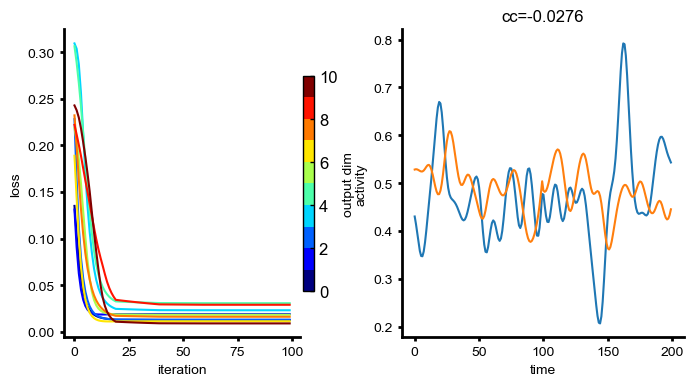

In [18]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
ax = axs[0]
cmap = pglm.discrete_cmap(vloss_trace.shape[-1],'jet')
for cell in range(vloss_trace.shape[-1]):
    ax.plot(vloss_trace[:,cell],c=cmap(cell))
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vloss_trace.shape[-1]))
cbar = fig.colorbar(sm,ax=ax,format=None,shrink=0.7,pad=0.01)
cbar.outline.set_linewidth(1)
cbar.set_label('output dim')
cbar.ax.tick_params(labelsize=12, width=1,direction='in')

ncell = 0
ax = axs[1]
ax.plot(yte[:,ncell])
ax.plot(yhat[:,ncell])
ax.set_xlabel('time')
ax.set_ylabel('activity')
ax.set_title('cc={:.03}'.format(np.corrcoef(yhat[:,ncell],yte[:,ncell])[1,0]))
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
x_all2,y_all2 = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=50,pytorch=False)
x_all2, y_all2 = x_all2.squeeze(),y_all2.squeeze()
y_all2 = (y_all2+1)/2
x_all2 = x_all2/np.max(np.abs(x_all2))
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all2.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all2.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr2,xte2 = x_all2[train_idx], x_all2[test_idx]
xtr_pos2,xte_pos2 = np.zeros_like(xtr2),np.zeros_like(xte2)
ytr2,yte2 = y_all2[train_idx], y_all2[test_idx]


l1 = LinearRegression()
l1.fit(xtr2,ytr2)
yhat2 = l1.predict(xte2)
print('cc=',np.corrcoef(yhat2[:,ncell],yte2[:,ncell])[0,1])

cc= -0.015062461290473502


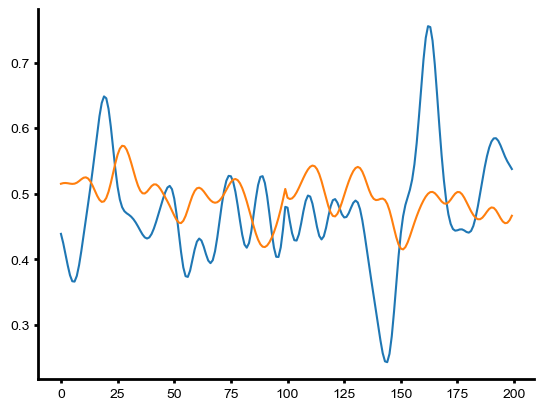

In [13]:
plt.plot(yte2[:,ncell])
plt.plot(yhat2[:,ncell])

# Ray Tune Training: Parallel Cross Validation

In [27]:
import ray
from ray import tune
from ray.air import session
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import hp

In [43]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
args['base_dir']        = '~/Research/SensoryMotorPred_Data/Testing'
args['fig_dir']         = '~/Research/SensoryMotorPred_Data/FigTesting'
args['data_dir']        = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['date_ani']        = '011523/TestAni'
args['stim_cond']       = 'Control'
args['Nepochs']         = 50
args['NoL1']            = True
args['NoL2']            = True
args['model_dt']        = 0

params, exp = load_BaseModel_params(args=args,exp_dir_name='CustomData',ModelID=0)

from sklearn.model_selection import GroupShuffleSplit

##### Generating data #####
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=10,pytorch=True)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = (x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)

##### Train/Test Splits ####
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr,xte = x_all[train_idx], x_all[test_idx]
xtr_pos,xte_pos = torch.zeros_like(xtr).float(),torch.zeros_like(xte).float()
ytr,yte = y_all[train_idx], y_all[test_idx]

print('X:',xtr.shape,'Xpos:',xtr_pos.shape,'y:',ytr.shape)
print('X:',xte.shape,'Xpos:',xte_pos.shape,'y:',yte.shape)

params['nk'] = xtr.shape[-1]
params['Ncells'] = ytr.shape[-1]
train_dataset = pglm.FreeMovingEphysDataset(xtr,xtr_pos,ytr)
test_dataset = pglm.FreeMovingEphysDataset(xte,xte_pos,yte)
meanbias = torch.mean(y_all,dim=0)

params['initW'] = 'normal' #'zero' # 'normal'
params['optimizer'] = 'sgd'
network_config = pglm.make_network_config(params,custom=True)
network_config['lr_w'] = tune.loguniform(1e-4, 1e-2)
network_config['lr_b'] = tune.loguniform(1e-2, 1)

X: torch.Size([800, 100]) Xpos: torch.Size([800, 100]) y: torch.Size([800, 10])
X: torch.Size([200, 100]) Xpos: torch.Size([200, 100]) y: torch.Size([200, 10])


In [44]:
network_config

{'in_features': 100,
 'Ncells': 10,
 'initW': 'normal',
 'optimizer': 'sgd',
 'lr_w': <ray.tune.search.sample.Float at 0x7f193acb36d0>,
 'lr_b': <ray.tune.search.sample.Float at 0x7f193acc19d0>,
 'lr_m': 0.001,
 'single_trial': None,
 'L1_alpha': None,
 'L1_alpham': None,
 'L2_lambda': 0,
 'L2_lambda_m': 0}

In [45]:
initial_params = [
    {"lr_w": 0.001,"lr_b": 0.1, },
]
algo = HyperOptSearch(points_to_evaluate=initial_params)
algo = ConcurrencyLimiter(algo, max_concurrent=4)
num_samples = 10

In [46]:

sync_config = tune.SyncConfig()  # the default mode is to use use rsync
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_network,params=params,train_dataset=train_dataset,test_dataset=test_dataset),
        resources={"cpu": 2, "gpu": .5}),
    tune_config=tune.TuneConfig(metric="avg_loss",mode="min",search_alg=algo,num_samples=num_samples),
    param_space=network_config,
    run_config=air.RunConfig(local_dir=params['save_model'], name="NetworkAnalysis",sync_config=sync_config,verbose=2)
)
results = tuner.fit()

best_result = results.get_best_result("avg_loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["avg_loss"]))
df = results.get_dataframe()
best_network = list(params['save_model'].glob('*{}.pt'.format(best_result.metrics['trial_id'])))[0]
pglm.h5store(params['save_model'] / 'NetworkAnalysis/experiment_data.h5', df, **{'best_network':best_network})

Trial name,avg_loss,should_checkpoint
train_network_07796106,0.113334,True
train_network_08e2e0f7,0.0462232,True
train_network_316a0af1,0.0188265,True
train_network_393ad4a3,0.0165167,True
train_network_5224df17,0.0434549,True
train_network_5a1b8f0d,0.015631,True
train_network_8e25638d,0.037612,True
train_network_a70395b4,0.172963,True
train_network_a753ecd4,0.0174897,True
train_network_c09b4746,0.0170802,True


(train_network pid=1657923) Finished Training
(train_network pid=1658139) Finished Training
(train_network pid=1657923) Finished Training
(train_network pid=1658139) Finished Training
(train_network pid=1657923) Finished Training
(train_network pid=1658139) Finished Training
(train_network pid=1657923) Finished Training
(train_network pid=1658139) Finished Training
(train_network pid=1657923) Finished Training


2023-01-13 11:20:43,117	INFO tune.py:762 -- Total run time: 68.07 seconds (67.94 seconds for the tuning loop).


(train_network pid=1658139) Finished Training
Best trial config: {'in_features': 100, 'Ncells': 10, 'initW': 'normal', 'optimizer': 'sgd', 'lr_w': 0.008895509683650736, 'lr_b': 0.5133115763129447, 'lr_m': 0.001, 'single_trial': None, 'L1_alpha': None, 'L1_alpham': None, 'L2_lambda': 0, 'L2_lambda_m': 0}
Best trial final validation loss: 0.01563102751970291


In [52]:
state_dict,optim2=torch.load(best_network)

odict_keys(['Cell_NN.0.weight', 'Cell_NN.0.bias'])